<a href="https://colab.research.google.com/github/ProfEddie/HypCLIP/blob/perceiver/lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from model.modules.dct import dct
from lavis.datasets.builders import load_dataset
from utils.data_utils import  get_loaders
from lavis.models import load_model_and_preprocess
import torch
import torch.nn as nn
import torch.nn.functional as  F
import matplotlib.pyplot as plt


/home/jarvis/anaconda3/envs/hada-v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
COCO_PATH = "/mnt/data/itr_dataset/dataset/coco/images"
FLICKR_PATH = "/mnt/data/itr_dataset/dataset/flickr30k/flickr30k_images"
dataset = load_dataset("flickr30k", vis_path=FLICKR_PATH, cfg_path=None)
model, vis_processors, txt_processors = load_model_and_preprocess("blip_retrieval", "flickr", is_eval=False)

Using downloaded and verified file: /mnt/data/itr_dataset/dataset/flickr30k/annotations/train.json
Using downloaded and verified file: /mnt/data/itr_dataset/dataset/flickr30k/annotations/val.json
Using downloaded and verified file: /mnt/data/itr_dataset/dataset/flickr30k/annotations/test.json


In [3]:

def plot_hidden_states(hidden_states, filtered=False):
  for hidden_state in hidden_states:
    hidden_state=hidden_state.permute(1,0,2)
    x_dct = dct(hidden_state.transpose(0,2), norm='ortho').transpose(0,2)
    if not filtered:
      numpy_array = ((x_dct.permute(1,0,2).mean(0).mean(1))).cpu().detach().numpy()
    else:
      numpy_array = ((x_dct.permute(1,0,2).mean(0).mean(1)))[:350].cpu().detach().numpy()
    plt.figure(figsize=(10, 2))

    # plt.imshow(numpy_array, cmap='viridis')  # You can choose a different colormap
    plt.plot(numpy_array)# You can choose a different colormap
    # plt.colorbar()
    plt.show()



In [4]:
from config import parser, config_dict, config_args, add_flags_from_config, argparse

parser = argparse.ArgumentParser()
for _, config_dict in config_args.items():
    parser = add_flags_from_config(parser, config_dict)


In [5]:
from lavis.models import load_model_and_preprocess
from model.modules.dct_models import DCTLAVISBlip


model, vis_processors, txt_processors = load_model_and_preprocess("blip_retrieval", "flickr", is_eval=False)
train_loader, val_loader, test_loader = get_loaders(
    10, 
    dataset,
    vis_processor=vis_processors['eval'],
    txt_processor=txt_processors['eval'],
    tokenizer=model.tokenizer,
)
device = torch.device('cpu')
model = DCTLAVISBlip(model, compress_method='std')


In [6]:
from transformers import AutoModel, AutoProcessor
from model.modules.dct_models import DCTHFClip
BLIP_BASE_COCO = "Salesforce/blip-itm-base-coco"
BLIP_LARGE_COCO = "Salesforce/blip-itm-large-coco"
CLIP_BASE_PATCH_32 = "openai/clip-vit-base-patch32"
CLIP_BASE_PATCH_16 = "openai/clip-vit-base-patch16"
CLIP_LARGE_PATCH_14 = "openai/clip-vit-large-patch14"
BLIP_BASE = "Salesforce/blip-image-captioning-base"
BLIP_BASE_FLICKR = "Salesforce/blip-itm-base-flickr"
BLIP_LARGE_FLICKR = "Salesforce/blip-itm-large-flickr"
BLIP_LARGE_FLICKR = "Salesforce/blip-itm-large-coco"
LAVIS_BLIP_BASE_FLICKR = "lavis-blip-itm-base-flickr"
LAVIS_BLIP_BASE_COCO= "lavis-blip-itm-base-coco"
model = AutoModel.from_pretrained(CLIP_LARGE_PATCH_14)
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model = DCTHFClip(model, 'std').to(device)
processor = AutoProcessor.from_pretrained(
    CLIP_BASE_PATCH_16
)
train_loader, val_loader, test_loader = get_loaders(
    40, 
    dataset,
    vis_processor=processor,
    txt_processor=None,
    tokenizer=processor,
)

  0%|          | 0/1000 [00:00<?, ?it/s]


torch.Size([1, 127, 1024])
torch.Size([1, 257, 1024])


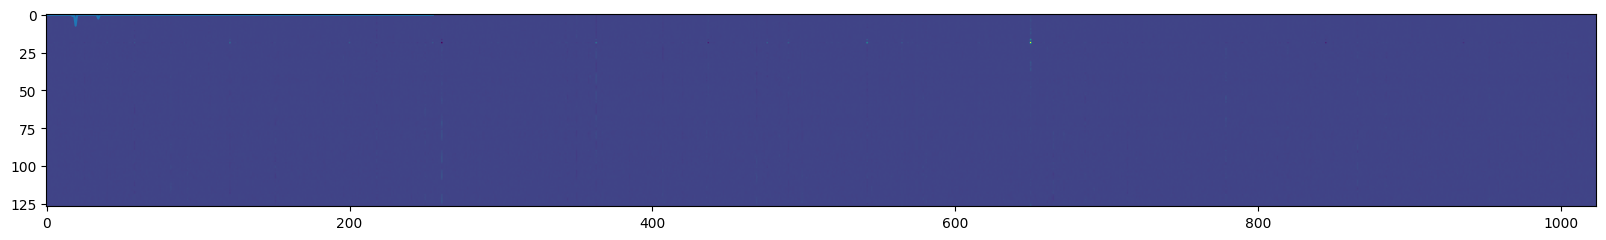

In [7]:
from tqdm.auto import tqdm
import numpy as np
for batch in tqdm(test_loader):
    break
with torch.no_grad():
    # print(batch['pixel_values'].shape)
    _,_, hidden_states,x_dct = model.get_vision_features(pixel_values=batch['pixel_values'].to(device), use_compressed_hidden_state=False,return_all_fourier_signals=True)
    _,_, filtered_hidden_states,x_dct_filtered = model.get_vision_features(pixel_values=batch['pixel_values'].to(device), use_compressed_hidden_state=True, return_all_fourier_signals=True)
    for i in range(len(filtered_hidden_states)):
        
        # filtered_hidden_state = filtered_hidden_states[i].permute(1,0,2)
        # hidden_state = hidden_states[i].permute(1,0,2)
        # x_dct_filtered = dct(filtered_hidden_state.transpose(0,2), norm='ortho').transpose(0,2)
        # x_dct = dct(hidden_state.transpose(0,2), norm='ortho').transpose(0,2)[:x_dct_filtered.shape[0],:, :]
        # x_dct_filtered =x_dct_filtered.permute(1,0,2)
        # x_dct = x_dct.permute(1,0,2)
        # threshold = 0.05 
        pred = x_dct_filtered[i]
        # pred = upsample(pred.permute(0,2,1)).permute(0,2,1)
        target = x_dct[i]
        print(pred.shape)
        print(hidden_states[i].shape)
        # pred_amplitude = torch.abs(x_dct_filtered[i])
      
        # x_dct_filtered_mean =pred.mean(0).mean(1)
        # x_dct_mean = target.mean(0).mean(1)
        # x_dct_filtered_mean =torch.abs(pred.mean(0).mean(1))
        # x_dct_mean = torch.abs(target.mean(0).mean(1))
        x_dct_filtered_mean =pred.mean(0)
        x_dct_mean = target.mean(0)
        x_dct_filtered_std =pred.mean(0).std(1) **2
        x_dct_mean_std = target.mean(0).std(1) **2
        # threshold =torch.quantile(x_dct_mean, 0.95, dim=-1, keepdim=True) 

        # indices = torch.where(x_dct_mean > threshold)
        # last_index = indices[0][-1].item() if indices[0].numel() > 0 else -1
        # print(threshold)
        # print(last_index)

        plt.figure(figsize=(20, 10))
        # plt.plot(x_dct_filtered_mean.mean(1).cpu().detach().numpy())
        plt.plot(x_dct_mean_std.cpu().detach().numpy())
        plt.imshow(x_dct_filtered_mean.cpu().detach().numpy())
        # plt.imshow(x_dct_mean.cpu().detach().numpy())
        # plt.plot(x_dct_mean)
        # plt.plot(x_dct_filtered_mean)
        plt.show()
      

# plot_hidden_states(hidden_states, filtered=True)

In [8]:
mask = torch.nonzero(x_dct_mean_std > 1).squeeze()

In [9]:
mask

tensor([19, 34])

In [10]:

import numpy as np

def find_spans(array, threshold):
    spans = []
    final_spans = []
    start = array[0]
    current_span = [start]

    for value in array[1:]:
        if value - start <= threshold:
            # Expand the current span
            current_span.append(value)
        else:
            # Start a new span
            spans.append((current_span[0], current_span[-1]))
            current_span = [value]
            start = value

    # Add the last span
    spans.append((current_span[0], current_span[-1]))
    begin = spans[0][0]
    end = spans[0][1]
    for i in range(len(spans)):
        if spans[i][0] - end <= threshold:
            print(spans[i])
            end = spans[i][1]
        
        else:
            final_spans.append([begin-5, end+5])
            begin = spans[i][1]
            end = spans[i+1][0]
            
    final_spans.append((begin-5, end+5))
    final_spans[0][0] = 0
    

    return final_spans

# Example usage:
sorted_array = mask.numpy() 
threshold = 10 
result = find_spans(sorted_array, threshold)

print("Spans with elements having a distance smaller than 5:", result)


(19, 19)


IndexError: list index out of range

In [ ]:
result

[[0, 83],
 [97, 120],
 [132, 155],
 [169, 287],
 [302, 436],
 [444, 488],
 (501, 535)]